# Load Libraries

In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from ast import literal_eval
import matplotlib.pyplot as plt
import tensorflow as tf

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

# Load CSV Files

In [2]:
movies = pd.read_csv('movies_metadata.csv')
movies.drop(['belongs_to_collection', 'homepage', 'poster_path', 'status', 'video'], axis = 1, inplace = True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 45466 non-null  object 
 1   budget                45466 non-null  object 
 2   genres                45466 non-null  object 
 3   id                    45466 non-null  object 
 4   imdb_id               45449 non-null  object 
 5   original_language     45455 non-null  object 
 6   original_title        45466 non-null  object 
 7   overview              44512 non-null  object 
 8   popularity            45461 non-null  object 
 9   production_companies  45463 non-null  object 
 10  production_countries  45463 non-null  object 
 11  release_date          45379 non-null  object 
 12  revenue               45460 non-null  float64
 13  runtime               45203 non-null  float64
 14  spoken_languages      45460 non-null  object 
 15  tagline            

In [3]:
movies.sort_values(by = 'adult', ascending = True).head(3)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
19730,- Written by Ørnås,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...",1997-08-20,0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,Avalanche Sharks tells the story of a bikini ...,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...",2014-01-01,0,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,Rune Balot goes to a casino connected to the ...,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...",2012-09-29,0,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There were three rows of data that are incorrect, so those are removed.

In [4]:
movies = movies.drop([19730, 35587, 29503])

In [5]:
credits = pd.read_csv('credits.csv')
print(credits.info())
credits.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB
None


,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862


In [6]:
ratings = pd.read_csv('ratings.csv')
print(ratings.info())
ratings.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 794.2 MB
None


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529


# Create a Merged Dataset

In [7]:
movies[['id']] = movies[['id']].astype('int64')
movies[['popularity', 'budget']] = movies[['popularity', 'budget']].astype('float64')

movies = movies.merge(credits, on = 'id')

# Deletion and Imputation

In [8]:
movies['original_language'] = movies['original_language'].fillna('')
movies['runtime'] = movies['runtime'].fillna(0)
movies['tagline'] = movies['tagline'].fillna('')

movies.dropna(inplace = True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44498 entries, 0 to 45537
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   adult                 44498 non-null  object 
 1   budget                44498 non-null  float64
 2   genres                44498 non-null  object 
 3   id                    44498 non-null  int64  
 4   imdb_id               44498 non-null  object 
 5   original_language     44498 non-null  object 
 6   original_title        44498 non-null  object 
 7   overview              44498 non-null  object 
 8   popularity            44498 non-null  float64
 9   production_companies  44498 non-null  object 
 10  production_countries  44498 non-null  object 
 11  release_date          44498 non-null  object 
 12  revenue               44498 non-null  float64
 13  runtime               44498 non-null  float64
 14  spoken_languages      44498 non-null  object 
 15  tagline               44

Some data entries are inputted weirdly, so, a function is used to extract the following data. 

In [9]:
movies.loc[0, 'genres']

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [10]:
def split_for_text(text, obj = 'name'):
    text = literal_eval(text)
    
    if len(text) == 1:
        for i in text:
            return i [obj]
    else:
        x = []
        for i in text:
            x.append(i[obj])
        return ', '.join(x)

In [11]:
process_columns = ['genres', 'production_companies', 'production_countries', 'crew', 'spoken_languages']

for col in process_columns:
    movies[col] = movies[col].apply(split_for_text, obj = 'name')
    
movies['actors'] = movies['cast'].apply(split_for_text, obj = 'name')
movies['characters'] = movies['cast'].apply(split_for_text, obj = 'character')

movies.drop('cast', axis = 1, inplace = True)
movies = movies[~movies['original_title'].duplicated()]
movies = movies.reset_index(drop = True)

# Visualization and Graphs

This graph looks at the relationship between the budgets for the movies and the revenues generated from the movie once released. When moving outwards and away from the epicenter, it seems like that the movies with more budget in the end would generate more revenue. 

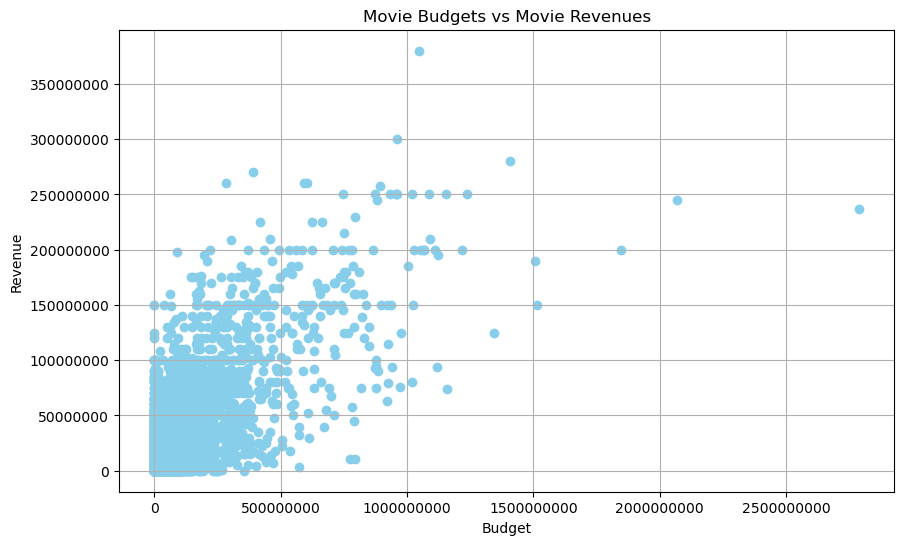

In [12]:
plt.figure(figsize = (10, 6))
plt.scatter(movies['revenue'], movies['budget'], color = 'skyblue', label = 'Data Points')
plt.title('Movie Budgets vs Movie Revenues')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.ticklabel_format(style = 'plain', axis = 'both')
plt.grid(True)
plt.show()

This graph showcases the dataset's collection of movies. There seems to be a lot more movies in this dataset that have been released around the 2000s.

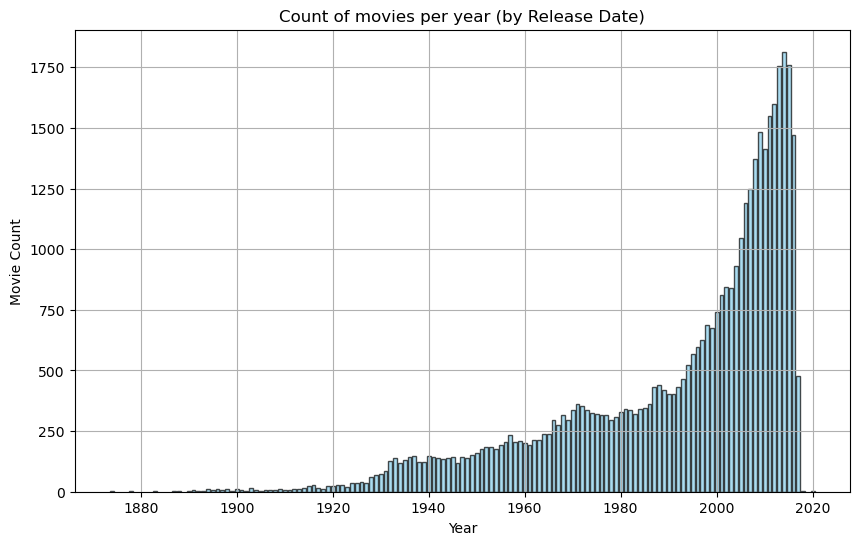

In [13]:
movies['year'] = pd.to_datetime(movies['release_date'], errors = 'coerce')
movies['year'] = movies['year'].dt.year
year_count = movies['year'].value_counts()

plt.figure(figsize = (10, 6))
plt.bar(year_count.index, year_count.values, color = 'skyblue', edgecolor = 'black', alpha = 0.7)
plt.title('Count of movies per year (by Release Date)')
plt.xlabel('Year')
plt.ylabel('Movie Count')
plt.grid(True)
plt.show()

This graphs shows the most frequent words used in movie overviews.

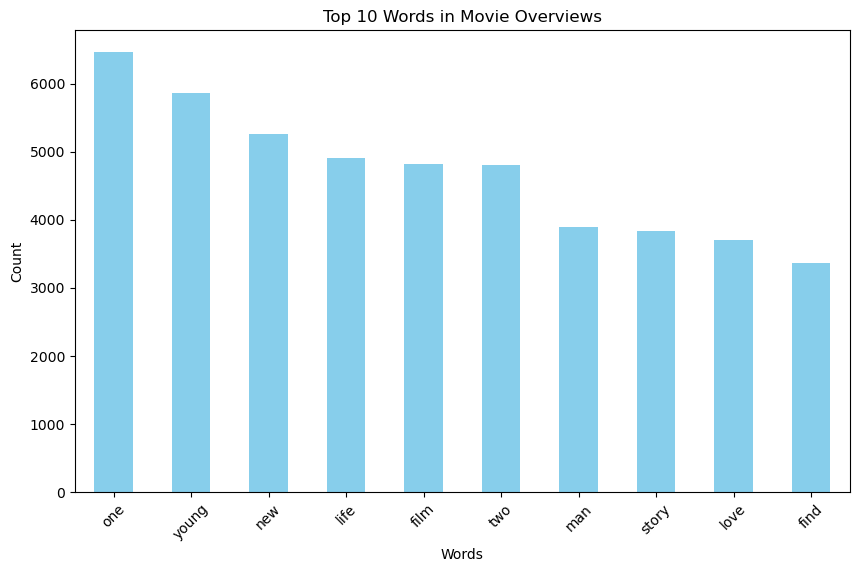

In [14]:
movies['overview'] = movies['overview'].fillna('')

words = ' '.join(movies['overview'].astype(str).str.lower()).split()
word_count = pd.Series(words).value_counts()
filler_words = set(stopwords.words('english'))

filtered_words = word_count[~word_count.index.isin(filler_words)].head(10)

plt.figure(figsize = (10, 6))
filtered_words.plot(kind = 'bar', color = 'skyblue')
plt.title('Top 10 Words in Movie Overviews')
plt.xlabel('Words')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.show()

The next following graphs shows the top 10 in different categories such as genres, production companies, production countries, actors, crew, and original languages.

In [15]:
column_list = ['genres', 'production_companies', 'production_countries', 'actors', 'crew', 'original_language']

list_genres = []
list_production_companies = []
list_production_countries = []
list_actors = []
list_crew = []
list_original_language = []

for col in column_list:
    for i in movies[col]:
        if isinstance(i, str):
            if col == 'genres':
                if i != '':
                    list_genres.extend(i.split(', '))
            elif col == 'production_companies':
                if i != '':
                    list_production_companies.extend(i.split(', '))
            elif col == 'production_countries':
                if i != '':
                    list_production_countries.extend(i.split(', '))
            elif col == 'actors':
                if i != '':
                    list_actors.extend(i.split(', '))
            elif col == 'crew':
                if i != '':
                    list_crew.extend(i.split(', '))
            elif col == 'original_language':
                if i != '':
                    list_original_language.extend(i.split(', '))

In [16]:
data_counts = [  
    (pd.Series(list_genres).value_counts().head(10), 'Top 10 Genres', 'Genres'),
    (pd.Series(list_production_companies).value_counts().head(10), 'Top 10 Production Companies', 'Production Companies'),
    (pd.Series(list_production_countries).value_counts().head(10), 'Top 10 Production Countries', 'Production Countries'),
    (pd.Series(list_actors).value_counts().head(10), 'Top 10 Actors', 'Actors'),
    (pd.Series(list_crew).value_counts().head(10), 'Top 10 Crews', 'Crews'),
    (pd.Series(list_original_language).value_counts().head(10), 'Top 10 Original Languages', 'Original Languages')
]

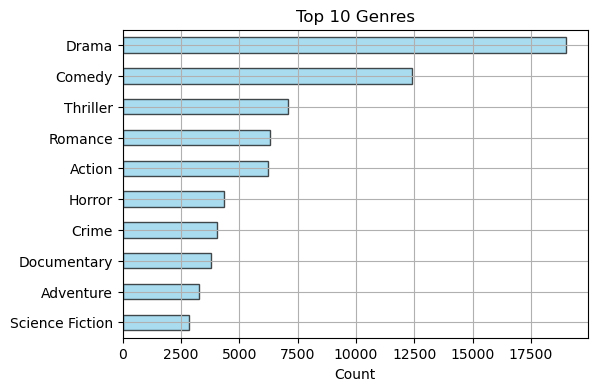

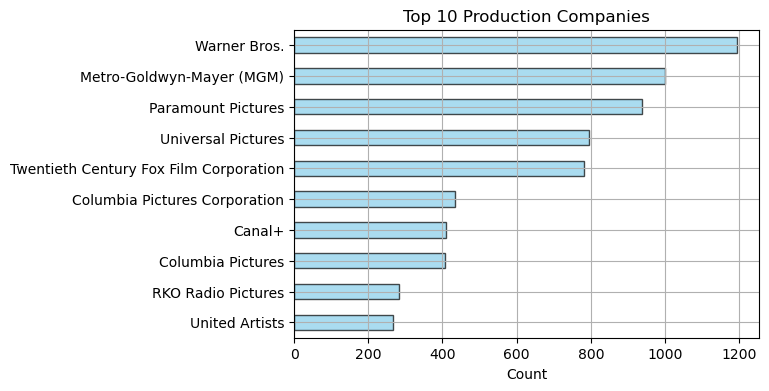

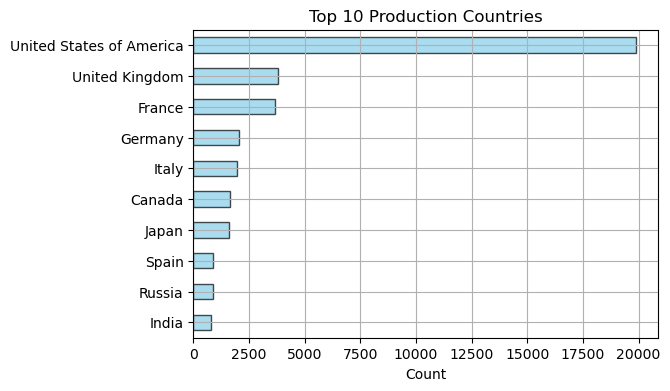

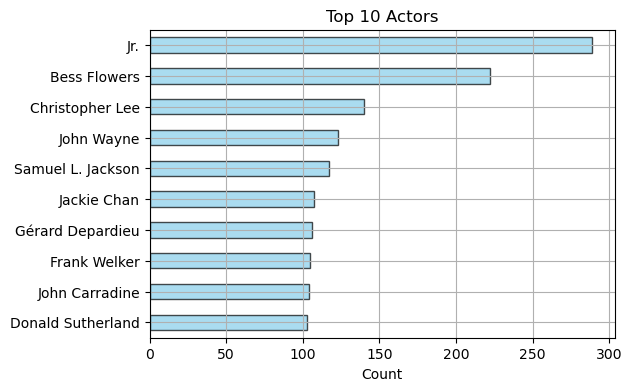

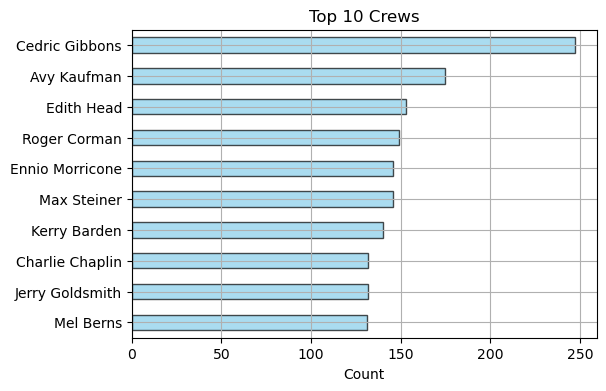

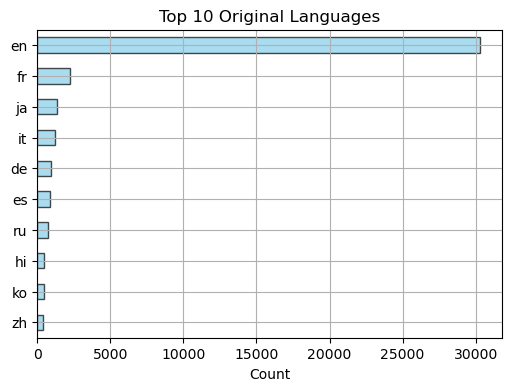

In [17]:
for data, title, xlabel in data_counts:
    plt.figure(figsize = (6, 4))
    data.sort_values().plot(kind = 'barh', color = 'skyblue', edgecolor = 'black', alpha = 0.7)
    plt.title(title)
    plt.xlabel('Count')
    plt.grid(True)
    plt.show()

The final visualization shows the correlation between every numerical variable that this dataset has against with each other in a heatmap. There seems to be high correlations between revenue and vote count as well as budget and revenue, which was showcased in an earlier graph.

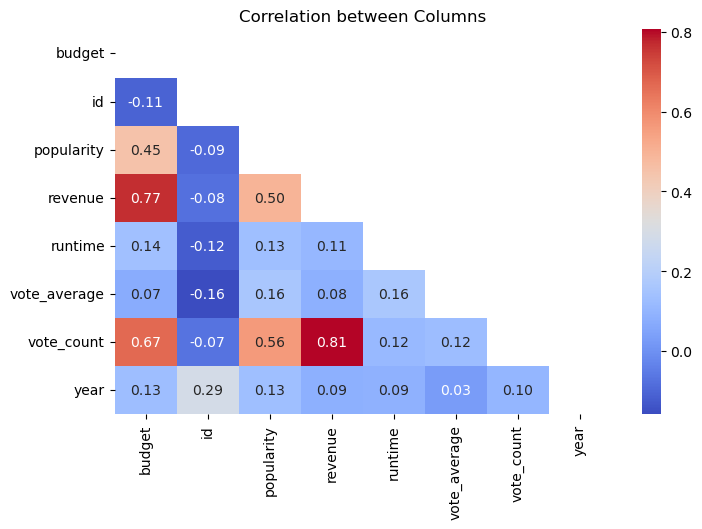

In [18]:
num_col = movies.select_dtypes(include = ['number']).columns

correlation_matrix = movies[num_col].corr()

plt.figure(figsize = (8, 5))
mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))
sns.heatmap(correlation_matrix, mask = mask, annot = True, cmap = 'coolwarm', fmt = '.2f', annot_kws = {'size': 10})
plt.title('Correlation between Columns')
plt.show()

# Identify Voting (Rating) of a Movie

According to IMDB, they have created a Weighted Average Formula, as some votes don't have the same impact, thus a weighted average must be taken.

Weighted Average Formula from IMDB: (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C

In [19]:
mean_vote = movies['vote_average'].mean()
print('Mean Vote:', mean_vote)
min_vote = movies['vote_count'].quantile(0.9)
print('Minimum Vote:', min_vote)

def rating(x, min_vote = min_vote, mean_vote = mean_vote):
    vote_count = x['vote_count']
    vote_average = x['vote_average']
    
    return (vote_count / (vote_count + min_vote) * vote_average) + (min_vote / (vote_count + min_vote) * mean_vote)

Mean Vote: 5.654431933526899
Minimum Vote: 161.0


In [20]:
movies['weighted_average'] = movies.apply(rating, axis = 1)
movies[['title', 'popularity', 'vote_count', 'vote_average', 'weighted_average']].sort_values('weighted_average', ascending = False).head(10)

,title,popularity,vote_count,vote_average,weighted_average
312,The Shawshank Redemption,51.645403,8358.0,8.5,8.446222
821,The Godfather,41.109264,6024.0,8.5,8.425928
10030,Dilwale Dulhania Le Jayenge,34.457024,661.0,9.1,8.425138
12107,The Dark Knight,123.167259,12269.0,8.3,8.265733
2796,Fight Club,63.869599,9678.0,8.3,8.256709
291,Pulp Fiction,140.950236,8670.0,8.3,8.251768
520,Schindler's List,41.725123,4436.0,8.3,8.207345
22568,Whiplash,64.299990,4376.0,8.3,8.206119
5391,Spirited Away,41.048867,3968.0,8.3,8.196843
2181,Life Is Beautiful,39.394970,3643.0,8.3,8.188029


In [21]:
scaler = MinMaxScaler()
scaled_movies = scaler.fit_transform(movies[['popularity', 'weighted_average']])

movies[['popularity', 'weighted_average']] = scaled_movies
movies['final_score'] = movies['weighted_average'] * 0.7 + movies['popularity'].astype('float64') * 0.3

movies.sort_values(by = 'final_score', ascending = False).head(5)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,...,tagline,title,vote_average,vote_count,crew,actors,characters,year,weighted_average,final_score
291,False,8000000.0,"Thriller, Crime",680,tt0110912,en,Pulp Fiction,"A burger-loving hit man, his philosophical par...",0.257449,"Miramax Films, A Band Apart, Jersey Films",...,Just because you are a character doesn't mean ...,Pulp Fiction,8.3,8670.0,"Quentin Tarantino, Quentin Tarantino, Roger Av...","John Travolta, Samuel L. Jackson, Uma Thurman,...","Vincent Vega, Jules Winfield, Mia Wallace, But...",1994,0.959898,0.749163
12107,False,185000000.0,"Drama, Action, Crime, Thriller",155,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,0.224968,"DC Comics, Legendary Pictures, Warner Bros., D...",...,Why So Serious?,The Dark Knight,8.3,12269.0,"Lucinda Syson, Hans Zimmer, Charles Roven, Chr...","Christian Bale, Michael Caine, Heath Ledger, A...","Bruce Wayne / Batman, Alfred Pennyworth, Joker...",2008,0.962778,0.741435
312,False,25000000.0,"Drama, Crime",278,tt0111161,en,The Shawshank Redemption,Framed in the 1940s for the double murder of h...,0.094332,"Castle Rock Entertainment, Warner Bros.",...,Fear can hold you prisoner. Hope can set you f...,The Shawshank Redemption,8.5,8358.0,"Frank Darabont, Niki Marvin, Thomas Newman, Ro...","Tim Robbins, Morgan Freeman, Bob Gunton, Clanc...","Andy Dufresne, Ellis Boyd 'Red' Redding, Warde...",1994,1.000000,0.728299
821,False,6000000.0,"Drama, Crime",238,tt0068646,en,The Godfather,"Spanning the years 1945 to 1955, a chronicle o...",0.075087,"Paramount Pictures, Alfran Productions",...,An offer you can't refuse.,The Godfather,8.5,6024.0,"Francis Ford Coppola, Francis Ford Coppola, Gr...","Marlon Brando, Al Pacino, James Caan, Richard ...","Don Vito Corleone, Michael Corleone, Santino '...",1972,0.995815,0.719596
23296,False,165000000.0,"Adventure, Family, Animation, Action, Comedy",177572,tt2245084,en,Big Hero 6,The special bond that develops between plus-si...,0.390602,"Walt Disney Pictures, Walt Disney Animation St...",...,From the creators of Wreck-it Ralph and Frozen,Big Hero 6,7.8,6289.0,"John Lasseter, Robert Richardson, Mark Henley,...","Scott Adsit, Ryan Potter, Daniel Henney, T.J. ...","Baymax (voice), Hiro Hamada (voice), Tadashi H...",2014,0.855685,0.716160


In [22]:
movies_text = movies[['original_title', 'adult', 'genres', 'overview', 'production_companies', 'tagline', 'crew', 'characters', 'actors']]

def remove_punctuation(text):
    return ''.join(char for char in text if char not in string.punctuation)

for col in movies_text.columns:
    movies_text[col] = movies_text[col].str.lower().apply(remove_punctuation)
    
movies['combined_text'] = movies_text.apply(lambda row: ' '.join(row), axis = 1)

movies.head(5)

,adult,budget,genres,id,imdb_id,original_language,original_title,overview,popularity,production_companies,...,title,vote_average,vote_count,crew,actors,characters,year,weighted_average,final_score,combined_text
0,False,30000000.0,"Animation, Comedy, Family",862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",0.040087,Pixar Animation Studios,...,Toy Story,7.7,5415.0,"John Lasseter, Joss Whedon, Andrew Stanton, Jo...","Tom Hanks, Tim Allen, Don Rickles, Jim Varney,...","Woody (voice), Buzz Lightyear (voice), Mr. Pot...",1995,0.833926,0.595774,toy story false animation comedy family led by...
1,False,65000000.0,"Adventure, Fantasy, Family",8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,0.031079,"TriStar Pictures, Teitler Film, Interscope Com...",...,Jumanji,6.9,2413.0,"Larry J. Franco, Jonathan Hensleigh, James Hor...","Robin Williams, Jonathan Hyde, Kirsten Dunst, ...","Alan Parrish, Samuel Alan Parrish / Van Pelt, ...",1995,0.665055,0.474863,jumanji false adventure fantasy family when si...
2,False,0.0,"Romance, Comedy",15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,0.021394,"Warner Bros., Lancaster Gate",...,Grumpier Old Men,6.5,92.0,"Howard Deutch, Mark Steven Johnson, Mark Steve...","Walter Matthau, Jack Lemmon, Ann-Margret, Soph...","Max Goldman, John Gustafson, Ariel Gustafson, ...",1995,0.487660,0.347780,grumpier old men false romance comedy a family...
3,False,16000000.0,"Comedy, Drama, Romance",31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",0.007049,Twentieth Century Fox Film Corporation,...,Waiting to Exhale,6.1,34.0,"Forest Whitaker, Ronald Bass, Ronald Bass, Ezr...","Whitney Houston, Angela Bassett, Loretta Devin...","Savannah 'Vannah' Jackson, Bernadine 'Bernie' ...",1995,0.440271,0.310304,waiting to exhale false comedy drama romance c...
4,False,0.0,Comedy,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,0.015320,"Sandollar Productions, Touchstone Pictures",...,Father of the Bride Part II,5.7,173.0,"Alan Silvestri, Elliot Davis, Nancy Meyers, Na...","Steve Martin, Diane Keaton, Martin Short, Kimb...","George Banks, Nina Banks, Franck Eggelhoffer, ...",1995,0.429116,0.304977,father of the bride part ii false comedy just ...


# Singular Movie Recommendation Model

This movie recommendation model will only take 20000 data entries as the total size is too much computational power that the computer isn't able to handle. From the 20000, it would calculate a cosine similarity to determine how similar the chosen movie is relative to the other recommended movies. 

In [23]:
movies_subset = movies[:20000]

vectorizer = TfidfVectorizer(stop_words = 'english', min_df = 5)
matrix = vectorizer.fit_transform(movies_subset['combined_text'])
matrix.shape

(20000, 43179)

In [24]:
cosine_sim = cosine_similarity(matrix)
cosine_sim.shape

(20000, 20000)

In [25]:
def get_similar_movies(movie_title, cosine_sim = cosine_sim, movies = movies):
    idx = movies.index[movies['original_title'] == movie_title].tolist()[0]

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:11] 
    
    similar_movies_indices = [i[0] for i in sim_scores]
    similarity_scores = [i[1] for i in sim_scores] 
    
    movies_info = movies[['original_title', 'final_score']].iloc[similar_movies_indices].copy()
    movies_info['similarity'] = similarity_scores
    
    return movies_info[['original_title', 'similarity', 'final_score']]

In [26]:
chosen_movie = 'Up'
get_similar_movies(chosen_movie).sort_values(by = 'final_score', ascending = False)

,original_title,similarity,final_score
12319,WALL·E,0.471828,0.607971
6130,Finding Nemo,0.432844,0.584803
14816,Toy Story 3,0.488103,0.577852
11228,Ratatouille,0.424377,0.565457
10671,Cars,0.488334,0.438545
10526,Ice Age: The Meltdown,0.425527,0.422011
13702,Cloudy with a Chance of Meatballs,0.434094,0.415407
3820,The Transformers: The Movie,0.422013,0.395470
16717,Cars 2,0.482010,0.323987
4785,Jimmy Neutron: Boy Genius,0.455685,0.296316


In [27]:
chosen_movie = 'Finding Nemo'
get_similar_movies(chosen_movie).sort_values(by = 'final_score', ascending = False)

,original_title,similarity,final_score
14816,Toy Story 3,0.582271,0.577852
2946,Toy Story 2,0.512690,0.534760
2212,A Bug's Life,0.541638,0.461111
10671,Cars,0.599814,0.438545
10526,Ice Age: The Meltdown,0.509154,0.422011
13702,Cloudy with a Chance of Meatballs,0.531575,0.415407
3820,The Transformers: The Movie,0.525568,0.395470
16717,Cars 2,0.574393,0.323987
13713,Battle for Terra,0.527477,0.319542
4785,Jimmy Neutron: Boy Genius,0.555183,0.296316


# Collaborative Filtering User Profiles

In [28]:
ratings['date'] = ratings['timestamp'].apply(lambda x: datetime.fromtimestamp(x))
ratings.drop('timestamp', axis = 1, inplace = True)

movie_ratings = ratings.merge(movies[['id', 'original_title', 'genres', 'overview']], left_on = 'movieId', right_on = 'id', how = 'left')
movie_ratings = movie_ratings[~movie_ratings['id'].isna()]
movie_ratings.drop('id', axis = 1, inplace = True)
movie_ratings.reset_index(drop = True, inplace = True)

movie_ratings.head(5)

,userId,movieId,rating,date,original_title,genres,overview
0,1,110,1.0,2015-03-09 15:52:09,Trois couleurs : Rouge,"Drama, Mystery, Romance",Red This is the third film from the trilogy by...
1,1,147,4.5,2015-03-09 16:07:15,Les Quatre Cents Coups,Drama,"For young Parisian boy Antoine Doinel, life is..."
2,1,858,5.0,2015-03-09 15:52:03,Sleepless in Seattle,"Comedy, Drama, Romance",A young boy who tries to set his dad up on a d...
3,1,1246,5.0,2015-03-09 15:52:36,Rocky Balboa,Drama,When he loses a highly publicized virtual boxi...
4,1,1968,4.0,2015-03-09 16:02:28,Fools Rush In,"Drama, Comedy, Romance",Alex Whitman (Matthew Perry) is a designer fro...


In [29]:
movie_ratings.shape

(10969249, 7)

This creates a mapping of all the unique movies in this dataframe and then pairs it with the original title.

In [30]:
unique_movies = movie_ratings.drop_duplicates(subset = 'movieId')
print(unique_movies.shape)

movie_title_mapping = dict(zip(unique_movies['movieId'], unique_movies['original_title']))
movie_title_mapping

(7113, 7)


{110: 'Trois couleurs : Rouge',
 147: 'Les Quatre Cents Coups',
 858: 'Sleepless in Seattle',
 1246: 'Rocky Balboa',
 1968: 'Fools Rush In',
 2762: 'Young and Innocent',
 2959: 'License to Wed',
 4226: 'Shriek If You Know What I Did Last Friday the Thirteenth',
 54503: 'Shuang ma lian huan',
 58559: 'Confession of a Child of the Century',
 96821: 'Cesare deve morire',
 5: 'Four Rooms',
 25: 'Jarhead',
 58: "Pirates of the Caribbean: Dead Man's Chest",
 64: 'Hable con ella',
 79: '英雄',
 141: 'Donnie Darko',
 260: 'The 39 Steps',
 339: 'Night on Earth',
 377: 'A Nightmare on Elm Street',
 605: 'The Matrix Revolutions',
 628: 'Interview with the Vampire',
 648: 'La belle et la bête',
 762: 'Monty Python and the Holy Grail',
 780: "La passion de Jeanne d'Arc",
 786: 'Almost Famous',
 788: 'Mrs. Doubtfire',
 1552: 'Parenthood',
 480: 'Monsoon Wedding',
 500: 'Reservoir Dogs',
 527: 'Once Were Warriors',
 1092: 'The Third Man',
 3101: 'I Love You to Death',
 4474: 'My Super Ex-Girlfriend',
 

This creates a mapping of all the genres for all the unique movies and then pairs it with the genres.

In [74]:
unique_genres = movie_ratings.drop_duplicates(subset = 'original_title')
print(unique_genres.shape)

movie_genre_mapping = dict(zip(unique_genres['original_title'], unique_genres['genres']))
movie_genre_mapping

(7113, 7)


{'Trois couleurs : Rouge': 'Drama, Mystery, Romance',
 'Les Quatre Cents Coups': 'Drama',
 'Sleepless in Seattle': 'Comedy, Drama, Romance',
 'Rocky Balboa': 'Drama',
 'Fools Rush In': 'Drama, Comedy, Romance',
 'Young and Innocent': 'Drama, Crime',
 'License to Wed': 'Comedy',
 'Shriek If You Know What I Did Last Friday the Thirteenth': 'Comedy',
 'Shuang ma lian huan': 'Action, Foreign',
 'Confession of a Child of the Century': 'Drama',
 'Cesare deve morire': 'Drama, Documentary',
 'Four Rooms': 'Crime, Comedy',
 'Jarhead': 'Drama, War',
 "Pirates of the Caribbean: Dead Man's Chest": 'Adventure, Fantasy, Action',
 'Hable con ella': 'Drama, Romance',
 '英雄': 'Drama, Adventure, Action, History',
 'Donnie Darko': 'Fantasy, Drama, Mystery',
 'The 39 Steps': 'Action, Thriller, Mystery',
 'Night on Earth': 'Comedy, Drama',
 'A Nightmare on Elm Street': 'Horror',
 'The Matrix Revolutions': 'Adventure, Action, Thriller, Science Fiction',
 'Interview with the Vampire': 'Horror, Romance',
 'La 

With a super large dataset, it's split up into size of arond 26,000 for each batch. This would make it easier to compute.

In [31]:
unique_user_ids = movie_ratings['userId'].unique()
batch_size = len(unique_user_ids) // 10

random_user_batch = np.random.choice(unique_user_ids, size = batch_size, replace = False)

movie_ratings_batch = movie_ratings[movie_ratings['userId'].isin(random_user_batch)]

profiles_batch = movie_ratings_batch.pivot(index = 'userId', columns = 'movieId', values = 'rating')
profiles_batch.fillna(0, inplace = True)
profiles_batch.sort_index(inplace = True)

profiles_batch

movieId,2,3,5,6,11,12,13,14,15,16,...,174593,174611,174615,174645,174759,174905,175287,175291,175331,175587
userId,,,,,,,,,,,,,,,,,,,,,
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270877,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270879,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
def similar_users(profiles, user):
    user_profile = profiles.loc[user].values.reshape(1, -1)
    
    score = cosine_similarity(user_profile, profiles)
    similarity_df = pd.DataFrame(score[0], index = profiles.index, columns = ['Similarity'])
    similarity_df.drop(user, inplace = True)
    
    top_similar_users = similarity_df.nlargest(5, 'Similarity').index.tolist()
    
    return top_similar_users

In [47]:
selected_user = 270879

similar_users(profiles_batch, selected_user)

[132852, 232330, 132971, 88566, 251234]

In [48]:
def display_users_data(profiles, user):
    user_data = profiles.loc[user]
    user_data = user_data.loc[:, (user_data != 0).any()]
    
    return user_data.transpose()

In [49]:
similar_user_ids = similar_users(profiles_batch, selected_user)
similar_user_ids.insert(0, selected_user)
similar_user_data = display_users_data(profiles_batch, similar_user_ids)
similar_user_data

userId,270879,132852,232330,132971,88566,251234
movieId,,,,,,
2,3.5,2.0,3.5,3.5,3.0,4.0
3,0.0,1.5,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,2.5,0.0,3.0
6,0.0,3.0,5.0,4.0,5.0,3.0
11,0.0,0.0,3.0,3.0,0.0,3.0
...,...,...,...,...,...,...
67087,0.0,0.0,0.0,0.0,0.0,2.0
68954,0.0,0.0,0.0,0.0,2.5,3.0
69406,0.0,0.0,0.0,0.0,3.0,0.0


In [50]:
similar_user_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 810 entries, 2 to 72701
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   270879  810 non-null    float64
 1   132852  810 non-null    float64
 2   232330  810 non-null    float64
 3   132971  810 non-null    float64
 4   88566   810 non-null    float64
 5   251234  810 non-null    float64
dtypes: float64(6)
memory usage: 44.3 KB


# Movie Reocmmendation Model

In [51]:
df = pd.DataFrame(similar_user_data)
df.index

Index([    2,     3,     5,     6,    11,    12,    14,    15,    16,    17,
       ...
       63859, 64116, 64499, 64983, 65435, 67087, 68954, 69406, 69526, 72701],
      dtype='int64', name='movieId', length=810)

In [52]:
df_long = df.stack().reset_index()
df_long.columns = ['movieId', 'userId', 'rating']
df_long

,movieId,userId,rating
0,2,270879,3.5
1,2,132852,2.0
2,2,232330,3.5
3,2,132971,3.5
4,2,88566,3.0
...,...,...,...
4855,72701,132852,0.0
4856,72701,232330,0.0
4857,72701,132971,0.0
4858,72701,88566,0.0


In [53]:
user_ids = df_long['userId'].unique().tolist()
movie_ids = df_long['movieId'].unique().tolist()

user_id_mapping = {id: i for i, id in enumerate(user_ids)}
movie_id_mapping = {id: i for i, id in enumerate(movie_ids)}

df_long['userId'] = df_long['userId'].map(user_id_mapping)
df_long['movieId'] = df_long['movieId'].map(movie_id_mapping)

In [54]:
train, test = train_test_split(df_long, test_size = 0.2, random_state = 25)

In [55]:
n_users = len(user_ids)
n_movies = len(movie_ids)

embedding_size = 50

def custom_loss(y_true, y_pred):
    mask = tf.where(tf.not_equal(y_true, 0))
    y_true_masked = tf.gather_nd(y_true, mask)
    y_pred_masked = tf.gather_nd(y_pred, mask)
    return tf.keras.losses.mean_squared_error(y_true_masked, y_pred_masked)

user_input = Input(shape = (1,), name = 'user_input')
user_embedding = Embedding(n_users, embedding_size, name = 'user_embedding')(user_input)
user_vec = Flatten(name = 'user_flatten')(user_embedding)

movie_input = Input(shape = (1,), name = 'movie_input')
movie_embedding = Embedding(n_movies, embedding_size, name = 'movie_embedding')(movie_input)
movie_vec = Flatten(name = 'movie_flatten')(movie_embedding)

concat = Concatenate()([user_vec, movie_vec])

dense = Dense(128, activation = 'relu')(concat)
dense = Dense(64, activation = 'relu')(dense)
output = Dense(1)(dense)

model = Model([user_input, movie_input], output)
model.compile(optimizer = 'adam', loss = custom_loss, metrics = ['mean_absolute_error'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │        300 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │     40,500 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_flatten        │ (None, 50)        │          0 │ user_embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_flatten       │ (None, 50)        │          0 │ movie_embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 100)       │          0 │ user_flatten[0][… │
│ (Concatenate)       │                   │            │ movie_flatten[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     12,928 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 62,049 (242.38 KB)

 Trainable params: 62,049 (242.38 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit(
    [train['userId'], train['movieId']], train['rating'],
    validation_data = ([test['userId'], test['movieId']], test['rating']),
    epochs = 10, batch_size = 6
)

Epoch 1/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: nan - mean_absolute_error: 1.9269 - val_loss: nan - val_mean_absolute_error: 2.3888
Epoch 2/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: nan - mean_absolute_error: 1.9928 - val_loss: nan - val_mean_absolute_error: 1.9861
Epoch 3/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - loss: nan - mean_absolute_error: 1.9304 - val_loss: nan - val_mean_absolute_error: 2.0232
Epoch 4/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mean_absolute_error: 1.9150 - val_loss: nan - val_mean_absolute_error: 2.1148
Epoch 5/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mean_absolute_error: 1.9457 - val_loss: nan - val_mean_absolute_error: 1.9635
Epoch 6/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step - loss: nan - mean_absolute_error: 1.9056 - val_loss: nan - val_mean_absolute_error: 2.0396
Epoch 7/10
648/648 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - loss: nan - mean_absolute_error: 1.8657 - val_loss: nan - val_mean_absolut

In [57]:
selected_user_id = user_id_mapping[selected_user]
selected_user_movies = similar_user_data.index[similar_user_data[selected_user] != 0].tolist()
movie_ids_predict = movie_ids

filtered_movie_ids = [movie for movie in movie_ids_predict if movie not in selected_user_movies]

movie_ids_predict_mapping = [movie_id_mapping[movie_id] for movie_id in filtered_movie_ids]

predictions = model.predict([np.array([selected_user_id] * len(movie_ids_predict_mapping)),
                            np.array(movie_ids_predict_mapping)])

predicted_ratings = {filtered_movie_ids[i]: rating for i, rating in enumerate(predictions.flatten())}
predicted_ratings = {movie_id: max(0, min(5, rating)) for movie_id, rating in predicted_ratings.items()}


predicted_ratings

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


{3: 2.618266,
 5: 3.0228014,
 6: 2.0914488,
 11: 2.7700987,
 12: 2.2411118,
 14: 2.1071572,
 15: 3.1314507,
 16: 3.502667,
 17: 2.5308266,
 19: 4.1773434,
 21: 2.2003198,
 22: 2.0882602,
 26: 3.1883569,
 58: 3.9728622,
 62: 2.7178297,
 65: 0.8829477,
 66: 2.0421143,
 70: 2.219386,
 71: 2.4500318,
 73: 3.5761485,
 76: 2.3205738,
 79: 2.6519961,
 86: 2.875773,
 95: 2.9895115,
 103: 2.6299047,
 104: 3.9156075,
 107: 2.1347585,
 110: 3.3079038,
 111: 2.9102483,
 112: 2.5995746,
 135: 2.2451735,
 141: 3.267016,
 153: 2.8534598,
 156: 2.2440763,
 158: 1.5277034,
 160: 3.286634,
 163: 2.4587278,
 164: 2.3296638,
 168: 2.771192,
 169: 2.6705132,
 170: 2.2091532,
 172: 3.1243405,
 173: 2.969192,
 175: 2.4415355,
 179: 2.722633,
 183: 2.249467,
 193: 2.8085356,
 194: 2.8218384,
 196: 2.856762,
 198: 2.0301313,
 204: 2.7867613,
 212: 1.0021162,
 215: 2.7247534,
 216: 2.7529464,
 224: 2.5952616,
 225: 2.2294655,
 227: 2.409274,
 231: 3.1783752,
 236: 1.9173591,
 247: 2.8167253,
 249: 2.4143229,
 2

In [71]:
def recommend_movies(predicted_ratings, title, genre, top = 5):
    rated_movies = {title[movie_id]: rating for movie_id, rating in predicted_ratings.items()}
    sorted_movies = sorted(rated_movies.items(), key = lambda x: x[1], reverse = True)
    
    top_rated_movies = sorted_movies[:top]
    
    recommended_df = pd.DataFrame(top_rated_movies, columns = ['Original Title', 'Rating'])
    
    return recommended_df

In [78]:
def recommend_movies(predicted_ratings, title_map, genre_map, top=5):
    rated_movies = {movie_id: (title_map[movie_id], genre_map[title_map[movie_id]], rating) for movie_id, rating in predicted_ratings.items()}
    
    sorted_movies = sorted(rated_movies.items(), key = lambda x: x[1][2], reverse = True)
    
    top_rated_movies = sorted_movies[:top]
    
    recommended_df = pd.DataFrame(top_rated_movies, columns = ['movieId', 'rating'])
    
    recommended_df['original_title'] = recommended_df['movieId'].map(lambda x: title_map[x])
    recommended_df['genres'] = recommended_df['movieId'].map(lambda x: genre_map[title_map[x]])
    
    recommended_df = recommended_df[['movieId', 'original_title', 'genres', 'rating']]

    recommended_df['rating'] = recommended_df['rating'].apply(lambda x: x[2])
    
    return recommended_df

recommended_movies_df = recommend_movies(predicted_ratings, movie_title_mapping, movie_genre_mapping)
recommended_movies_df

,movieId,original_title,genres,rating
0,3114,The Searchers,Western,5.000000
1,54272,座頭市関所破り,"Adventure, Action, Drama",4.551795
2,848,Dragonslayer,Fantasy,4.463926
3,6934,Yesterday,Drama,4.457967
4,1246,Rocky Balboa,Drama,4.446485
